## Imports

In [55]:
import torch
import logging
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import pandas as pd
from time import sleep
import json
import matplotlib.colors as mcolors
logging.basicConfig(level=logging.INFO)# OPTIONAL
import numpy as np; np.random.seed(42)
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D

## MAC Settings

In [56]:
print(f"PyTorch version: {torch.__version__}")
# Set the device      
device = "mps" if torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

PyTorch version: 1.13.1
Using device: mps


## Definitions

In [57]:
#TEMPLATES
EVALUATION_PATH = '../data/evaluation/'
RESULTS_PATH = '../data/results/'
ALBERT_BASE_TEMPLATE_1 = 'ALBERTbase[1]'
ALBERT_BASE_TEMPLATE_5 = 'ALBERTbase[5]'
ALBERT_LARGE_TEMPLATE_1 = 'ALBERTlarge[1]'
ALBERT_LARGE_TEMPLATE_5 = 'ALBERTlarge[5]'
BERT_BASE_TEMPLATE_1 = 'BERTbase[1]'
BERT_BASE_TEMPLATE_5 = 'BERTbase[5]'
BERT_LARGE_TEMPLATE_1 = 'BERTlarge[1]'
BERT_LARGE_TEMPLATE_5 = 'BERTlarge[5]'
ROBERTA_BASE_TEMPLATE_1 = 'RoBERTabase[1]'
ROBERTA_BASE_TEMPLATE_5 = 'RoBERTabase[5]'
ROBERTA_LARGE_TEMPLATE_1 = 'RoBERTalarge[1]'
ROBERTA_LARGE_TEMPLATE_5 = 'RoBERTalarge[5]'
BERTWEET_BASE_TEMPLATE_1 = 'BERTweetbase[1]'
BERTWEET_BASE_TEMPLATE_5 = 'BERTweetbase[5]'
BERTWEET_LARGE_TEMPLATE_1 = 'BERTweetlarge[1]'
BERTWEET_LARGE_TEMPLATE_5 = 'BERTweetlarge[5]'

MODELS =[ALBERT_BASE_TEMPLATE_1, ALBERT_BASE_TEMPLATE_5, ALBERT_LARGE_TEMPLATE_1, ALBERT_LARGE_TEMPLATE_5, 
         BERT_BASE_TEMPLATE_1, BERT_BASE_TEMPLATE_5, BERT_LARGE_TEMPLATE_1, BERT_LARGE_TEMPLATE_5,
         ROBERTA_BASE_TEMPLATE_1, ROBERTA_BASE_TEMPLATE_5, ROBERTA_LARGE_TEMPLATE_1, ROBERTA_LARGE_TEMPLATE_5,
         BERTWEET_BASE_TEMPLATE_1, BERTWEET_BASE_TEMPLATE_5, BERTWEET_LARGE_TEMPLATE_1, BERTWEET_LARGE_TEMPLATE_5]

MODELS_NAMES = ['ALBERTbase[1]','ALBERTbase[5]','ALBERTlarge[1]','ALBERTlarge[5]',
                'BERTbase[1]','BERTbase[5]','BERTlarge[1]','BERTlarge[5]', 
                'RoBERTabase[1]','RoBERTabase[5]','RoBERTalarge[1]','RoBERTalarge[5]',
                'BERTweetbase[1]','BERTweetbase[5]','BERTweetlarge[1]','BERTweetlarge[5]']

NEO_ROW = 0
NEUTRAL_ROW = 1
BINARY_ROW = 2
QUEER_IDENTITY = 3
QUEER_ORIENTATION = 4
QUEER_OTHER = 5
NON_QUEER_IDENTITY = 6
NON_QUEER_ORIENTATION = 7
NON_QUEER_OTHER = 8
QUEER_ROW = 9
NON_QUEER_ROW = 10 

#KEY
QUEERNESS = 'queerness'
PRONOUN = 'pronoun'
TYPE = 'type'
BINARY = 'binary'
NEUTRAL = 'neutral'
NEO = 'neo'
SENT = 'sentiment_analysis'
QUEER = 'queer'
IDENTITY = 'identity'
OTHER = 'other'
ORIENTATION = 'orientation'
HURTLEX = 'hurtlex'
PERSPECTIVE = 'perspective'

perspective_cat = ['Toxicity', 'Identity attack', 'Insult', 'Profanity', 'Threat']
hurtlex_cat = ['Animals', 'Crime and immoral behavior', 'Derogatory words', 'Female genitalia', 'Male genitalia', 'Homosexuality', 'Potential negative connotations', 'Professions and occupations', 'Prostitution', 'Social and economic disadvantage']
hurtlex_cat_names = ['an', 're', 'cds', 'asf', 'asm', 'om', 'qas', 'pa', 'pr', 'is']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

In [58]:
def truncate_float(float_number, decimal_places = 2):
    multiplier = 10 ** decimal_places
    return int(float_number * multiplier) / multiplier

# Graph

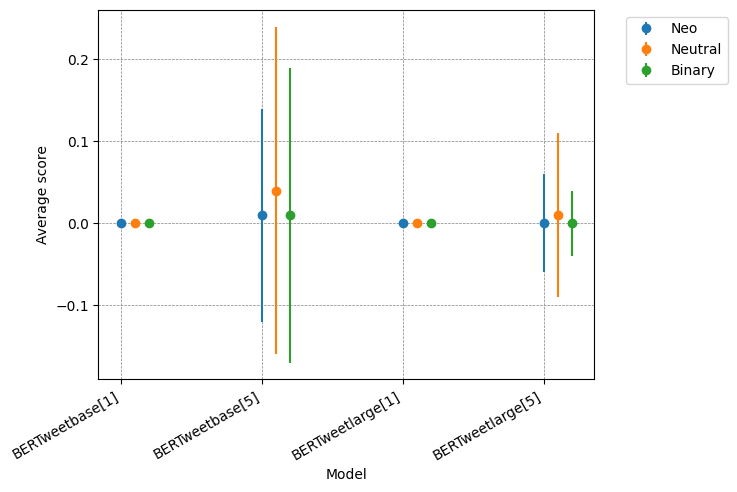

In [69]:
def error_bar(models):
    x = []
    y1_neo, y2_neutral, y3_binary= [], [], []
    yerr1_neo, yerr2_neutral, yerr3_binary = [], [], []
    for m in models:
        csv = pd.read_csv(RESULTS_PATH+m+'_afinn.csv', sep=";")
        x.append(m)
        y1_neo.append(csv.loc[NEO_ROW]['Score'])
        y2_neutral.append(csv.loc[NEUTRAL_ROW]['Score'])
        y3_binary.append(csv.loc[BINARY_ROW]['Score'])
        yerr1_neo.append(csv.loc[NEO_ROW]['StDev'])
        yerr2_neutral.append(csv.loc[NEUTRAL_ROW]['StDev'])
        yerr3_binary.append(csv.loc[BINARY_ROW]['StDev'])
    #x = list("ABC")
    #y1_neo, y2_neutral, y3_binary= [0.5, 1.2, 0.7], [0.7, 1.5, 2], [1.7, 0.5, 2]
    #yerr1_neo, yerr2_neutral, yerr3_binary = np.random.rand(3, len(x))*4+0.3
    # print(y1_neo)
    # print(y2_neutral)
    # print(y3_binary)
    fig, ax = plt.subplots()
    plt.style.use('default')
    plt.xticks(rotation=30)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
   
    
    
    trans1 = Affine2D().translate(0.0, 0.0) + ax.transData
    trans2 = Affine2D().translate(+0.1, 0.0) + ax.transData
    trans3 = Affine2D().translate(+0.2, 0.0) + ax.transData
    er1 = ax.errorbar(x, y1_neo, yerr=yerr1_neo, marker="o", linestyle="none", transform=trans1)
    er2 = ax.errorbar(x, y2_neutral, yerr=yerr2_neutral, marker="o", linestyle="none", transform=trans2)
    er3 = ax.errorbar(x, y3_binary, yerr=yerr3_binary, marker="o", linestyle="none", transform=trans3)
    plt.ylabel("Average score")
    plt.xlabel("Model")
    ax.legend(['Neo', 'Neutral', 'Binary'], bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

    plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    plt.show()

error_bar([BERTWEET_BASE_TEMPLATE_1, BERTWEET_BASE_TEMPLATE_5,BERTWEET_LARGE_TEMPLATE_1, BERTWEET_LARGE_TEMPLATE_5])

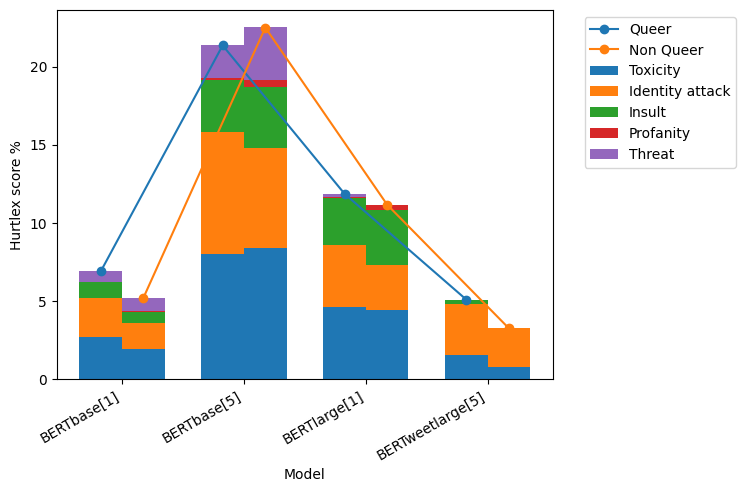

In [71]:
def perspective_linebar(models):
    x_labels, bar_data1, bar_data2, line_data1, line_data2 = [], [], [], [], []
    tox_queer, id_queer, ins_queer, prof_queer, thre_queer, tox_non, id_non, ins_non, prof_non, thre_non = [], [], [], [], [], [], [], [], [], []
    data1 = [tox_queer, id_queer, ins_queer, prof_queer, thre_queer]
    data2 = [tox_non, id_non, ins_non, prof_non, thre_non]
    for m in models:
        csv = pd.read_csv(RESULTS_PATH+m+'_perspective.csv', sep=";", index_col=[0])
        x_labels.append(m)
        for ind, d in enumerate(data1):
            d.append((csv.loc['Queer'][perspective_cat[ind]]/csv.loc['Queer']['Tot'])*100)
        for ind, d in enumerate(data2):
            d.append((csv.loc['Non Queer'][perspective_cat[ind]]/csv.loc['Non Queer']['Tot'])*100)

        line_data1.append(csv.loc['Queer']['Score'])
        line_data2.append(csv.loc['Non Queer']['Score'])

    for d in data1:
        bar_data1.append(d)
    for d in data2:
        bar_data2.append(d)
       
    #Set the width of the bars
    bar_width = 0.35
    # Create an array of x values for the bars
    x = np.arange(len(x_labels))
    # Create the figure and axis objects
    fig, ax1 = plt.subplots()
    # Predefined colors for bars and lines
    
    bar_colors = [mcolors.TABLEAU_COLORS[c] for c in colors]
    # Create the first set of bars
    bottom1 = np.zeros(len(x_labels))
    for i, data in enumerate(bar_data1):
        ax1.bar(x - bar_width/2, data, width=bar_width, label=f'{perspective_cat[i]}', color= bar_colors[i], bottom=bottom1)
        bottom1 += data

    # Create the second set of bars
    bottom2 = np.zeros(len(x_labels))
    for i, data in enumerate(bar_data2):
        ax1.bar(x + bar_width/2, data, width=bar_width, color= bar_colors[i], bottom=bottom2)
        bottom2 += data

    # Create the first set of line plots
    #ax2 = ax1.twinx()  # Create a twin y-axis
    ax1.plot(x - bar_width/2, line_data1, marker='o', label='Queer')
    
    # Create the second set of line plots
    ax1.plot(x + bar_width/2, line_data2, marker='o', label='Non Queer')

    # Set labels and legends
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Hurtlex score %')
    #ax1.set_ylabel('Score', color='black')
    ax1.set_xticks(x)
    ax1.set_xticklabels(x_labels)
    ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.xticks(rotation=30)
    plt.setp(ax1.xaxis.get_majorticklabels(), ha='right')
    # Show the graph
    plt.show()

perspective_linebar([BERT_BASE_TEMPLATE_1, BERT_BASE_TEMPLATE_5, BERT_LARGE_TEMPLATE_1, BERTWEET_LARGE_TEMPLATE_5])


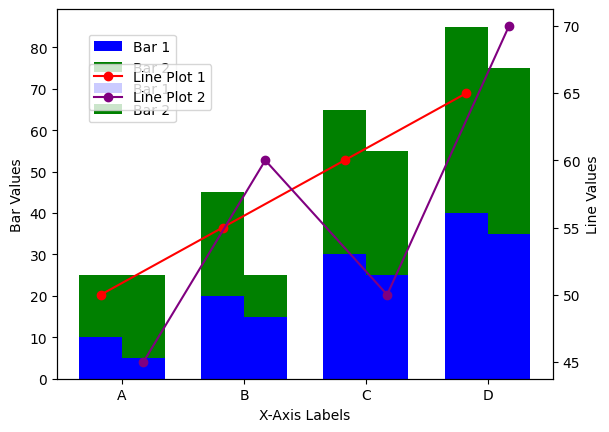

In [61]:
def hurtlex_linebar(models):
    x_labels, bar_data1, bar_data2, line_data1, line_data2 = [], [], [], [], []
    tox_queer, id_queer, ins_queer, prof_queer, thre_queer, tox_non, id_non, ins_non, prof_non, thre_non = [], [], [], [], [], [], [], [], [], []
    data1 = [tox_queer, id_queer, ins_queer, prof_queer, thre_queer]
    data2 = [tox_non, id_non, ins_non, prof_non, thre_non]
    for m in models:
        csv = pd.read_csv(RESULTS_PATH+m+'_perspective.csv', sep=";", index_col=[0])
        x_labels.append(m)
        for ind, d in enumerate(data1):
            d.append((csv.loc['Queer'][perspective_cat[ind]]/csv.loc['Queer']['Tot'])*100)
        for ind, d in enumerate(data2):
            d.append((csv.loc['Non Queer'][perspective_cat[ind]]/csv.loc['Non Queer']['Tot'])*100)

        line_data1.append(csv.loc['Queer']['Score'])
        line_data2.append(csv.loc['Non Queer']['Score'])

    for d in data1:
        bar_data1.append(d)
    for d in data2:
        bar_data2.append(d)
       
    #Set the width of the bars
    bar_width = 0.35
    # Create an array of x values for the bars
    x = np.arange(len(x_labels))
    # Create the figure and axis objects
    fig, ax1 = plt.subplots()
    # Predefined colors for bars and lines
    
    bar_colors = [mcolors.TABLEAU_COLORS[c] for c in colors]
    # Create the first set of bars
    bottom1 = np.zeros(len(x_labels))
    for i, data in enumerate(bar_data1):
        ax1.bar(x - bar_width/2, data, width=bar_width, label=f'{perspective_cat[i]}', color= bar_colors[i], bottom=bottom1)
        bottom1 += data

    # Create the second set of bars
    bottom2 = np.zeros(len(x_labels))
    for i, data in enumerate(bar_data2):
        ax1.bar(x + bar_width/2, data, width=bar_width, color= bar_colors[i], bottom=bottom2)
        bottom2 += data

    # Create the first set of line plots
    #ax2 = ax1.twinx()  # Create a twin y-axis
    ax1.plot(x - bar_width/2, line_data1, marker='o', label='Queer')
    
    # Create the second set of line plots
    ax1.plot(x + bar_width/2, line_data2, marker='o', label='Non Queer')

    # Set labels and legends
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Hurtlex score %')
    #ax1.set_ylabel('Score', color='black')
    ax1.set_xticks(x)
    ax1.set_xticklabels(x_labels)
    ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.xticks(rotation=30)
    plt.setp(ax1.xaxis.get_majorticklabels(), ha='right')
    # Show the graph
    plt.show()

perspective_linebar([BERT_BASE_TEMPLATE_1, BERT_BASE_TEMPLATE_5, BERT_LARGE_TEMPLATE_1, BERTWEET_LARGE_TEMPLATE_5])
